In [2]:
import numpy as np
%matplotlib inline
from pyqubo import Array, Placeholder, Constraint
import matplotlib.pyplot as plt
import networkx as nx
import neal
import csv
import os

In [3]:
def parse_tsp_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    node_coord_section = False
    node_matrix = []
    distance_matrix = None

    for line in lines:
        if line.startswith("NODE_COORD_SECTION"):
            node_coord_section = True
            continue
        elif line.startswith("EOF"):
            break

        if node_coord_section:
            node_info = line.split()
            node_id = int(node_info[0])
            # x_coord = int(float(node_info[1]))  # Convert to int
            # y_coord = int(float(node_info[2]))  # Convert to int
            x_coord = float(node_info[1])  # Convert to int
            y_coord = float(node_info[2])  # Convert to int

            node_matrix.append([node_id, x_coord, y_coord])

    node_matrix = np.array(node_matrix)

    # Calculate distance matrix (as in the previous version)
    num_nodes = node_matrix.shape[0]
    distance_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(num_nodes):
        for j in range(num_nodes):
            x1, y1 = node_matrix[i, 1], node_matrix[i, 2]
            x2, y2 = node_matrix[j, 1], node_matrix[j, 2]
            distance_matrix[i, j] = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    return node_matrix, distance_matrix

In [4]:
def plot_city(cities, sol=None):
    n_city = len(cities)
    cities_dict = dict(cities)
    G = nx.Graph()
    for city in cities_dict:
        G.add_node(city)
        
    # draw path
    if sol:
        city_order = []
        for i in range(n_city):
            for j in range(n_city):
                if sol.array('c', (i, j)) == 1:
                    city_order.append(j)
        for i in range(n_city):
            city_index1 = city_order[i]
            city_index2 = city_order[(i+1) % n_city]
            G.add_edge(cities[city_index1][0], cities[city_index2][0])

    plt.figure(figsize=(3,3))
    pos = nx.spring_layout(G)
    nx.draw_networkx(G, cities_dict)
    plt.axis("off")
    plt.show()

def dist(i, j, cities):
    pos_i = cities[i][1]
    pos_j = cities[j][1]
    return np.sqrt((pos_i[0] - pos_j[0])**2 + (pos_i[1] - pos_j[1])**2)

In [5]:
def process_tsp_files_in_folder(folder_name, num_cities_in_a_instance=30):
    if not os.path.exists(folder_name):
        raise ValueError(f"Folder '{folder_name}' does not exist.")

    files_in_folder = [file for file in os.listdir(folder_name) if os.path.isfile(os.path.join(folder_name, file))]

    for file_name in files_in_folder:
        if file_name.endswith('.tsp'):
            file_path = os.path.join(folder_name, file_name)

    return file_path

In [6]:
def solve_for_instances(file_path, nodes_matrix, relaxation_parameter, num_cities_in_a_instance=20):
    cities = [(i,(0,0)) for i in range(num_cities_in_a_instance)]
    n_mat = nodes_matrix.copy()
    for i in range(num_cities_in_a_instance):
        cities[i] = (str(n_mat[i][0]), (n_mat[i][1], n_mat[i][2]))
    #plot_city(cities)
    #print(cities)

    ## Prepare binary vector with bit (𝑖,𝑗) representing to visit 𝑗 city at time 𝑖
    n_city = len(cities)
    x = Array.create('c', (n_city, n_city), 'BINARY')
    # print(x)

    ## Constraint not to visit more than two cities at the same time.
    ## equation (6) implemented here
    ## time_const + city_const = H_a
    time_const = 0.0
    for i in range(n_city):
        # If you wrap the hamiltonian by Const(...), this part is recognized as constraint
        time_const += Constraint((sum(x[i, j] for j in range(n_city)) - 1)**2, label="time{}".format(i))

    ## Constraint not to visit the same city more than twice.
    city_const = 0.0
    for j in range(n_city):
        city_const += Constraint((sum(x[i, j] for i in range(n_city)) - 1)**2, label="city{}".format(j))

    # print("time_const: ", time_const)
    # print("city_const: ", city_const)

    ## distance of route
    ## equation (5) implemented here
    distance = 0.0
    for i in range(n_city):
        for j in range(n_city):
            for k in range(n_city):
                d_ij = dist(i, j, cities)
                distance += d_ij * x[k, i] * x[(k+1)%n_city, j]  # sum(d_uv) in eq.5 i.e. H_b

    # print("distance: ", distance)

    ## Construct hamiltonian
    A = Placeholder("A")  # the relaxation parameter
    H = distance + A * (time_const + city_const)  # Eq (4)

    # print("Relaxation Parameter A: ", A)
    # print("Hamiltonian H: ", H)

    ## Compile model
    model = H.compile()

    ## Generate QUBO
    ## maybe we can add a loop to go through different relaxation parameter here
    feed_dict = {'A': relaxation_parameter}  # setting it to upper bound of the coordinate works!!!
    bqm = model.to_bqm(feed_dict=feed_dict)


    sa = neal.SimulatedAnnealingSampler()
    sampleset = sa.sample(bqm, num_reads=128, num_sweeps=100)

    # Decode solution
    decoded_samples = model.decode_sampleset(sampleset, feed_dict=feed_dict)
    best_sample = min(decoded_samples, key=lambda x: x.energy)
    energy = best_sample.energy
    num_broken = len(best_sample.constraints(only_broken=True))
    infeasible_ctr = 0
    if num_broken == 0:
        print(energy)
        infeasible_ctr = 0
    for i in range(128):
        if len(decoded_samples[i].constraints(only_broken=True)) > 0:
            infeasible_ctr += 1
    P_f = (128-infeasible_ctr)/128
    return P_f, energy

In [40]:
def param_bin_search(folder_name):
    file_path = process_tsp_files_in_folder(folder_name)
    nodes_matrix, distance_matrix = parse_tsp_file(file_path)
    lower_bound = 0
    upper_bound = 10000
    mid = 0
    lb_found = False
    ub_found = False
    log_scale = [10**i for i in range(5)]
    for i in log_scale:
        p_f, energy = solve_for_instances(file_path,nodes_matrix,i)
        print(i,'->',p_f)
        if p_f > 0 and p_f < 0.1:
            lower_bound = i
            break
        elif p_f == 0:
            lower_bound= 0
        elif p_f > 0.9 and p_f < 1 :
            upper_bound = i
            break
        elif p_f == 1:
            upper_bound = i
    while lower_bound<=upper_bound and not ub_found:
        mid = (upper_bound + lower_bound)//2
        p_f, energy = solve_for_instances(file_path,nodes_matrix,mid)
        print(mid,"->", p_f)
        if p_f ==0 :
            lower_bound = mid
        elif p_f ==1:
            upper_bound = mid
        elif p_f < 1 and p_f >= 0.9:
            upper_bound = mid
            ub_found = True
        else:
            lower_bound = mid   
    upper_bound1 = upper_bound
    while lower_bound<=upper_bound and not lb_found :
        mid = (upper_bound + lower_bound)//2
        p_f, energy = solve_for_instances(file_path,nodes_matrix,mid)
        print(mid, "->", p_f)
        if p_f ==0 :
            lower_bound = mid
        elif p_f ==1:
            upper_bound = mid
        elif p_f > 0 and p_f <= 0.15:
            lower_bound = mid
            lb_found = True
        else:
            upper_bound = mid
        
    return upper_bound1, lower_bound

    

In [41]:
param_bin_search("TestTSPFolder")

1 -> 0.0
10 -> 0.0
477.69724558965345
100 -> 1.0
512.2498805833457
1000 -> 1.0
571.8650433152216
10000 -> 1.0
574.2656444365566
5000 -> 1.0
563.5553154359077
2500 -> 1.0
578.778071426379
1250 -> 1.0
474.445404218357
625 -> 1.0
466.8974644430382
312 -> 1.0
501.0891175715251
156 -> 1.0
386.00914346008767
78 -> 0.9921875
39 -> 0.1875
19 -> 0.0
29 -> 0.0078125


(78, 29)

326.7093425703508
361.9786875102527
345.99828317476386
352.3531626225781
366.9064657021288
374.27158033021396
364.13732675304095
391.13581840795314
390.98674577490556
420.46139573585606
384.792772236005
393.7423150421282
409.18225489523957
402.8737987992404
404.8346805719125
418.74590099981833
421.6805089417139
435.1429154750581
415.9135347358729
401.0781454221292
411.59865330830416
423.7396593559247
406.8597477069957
386.29087845282675
410.6697169080471
406.6371855623729
415.9211368767392
426.7512478470744
421.07596559142166
435.9304265135679
430.61584748866335
443.1479354866351
396.39454784577947
457.4747003657758
476.48765857156513
403.37249917839154
467.33679891462816
467.87128495424395
448.59302364276664


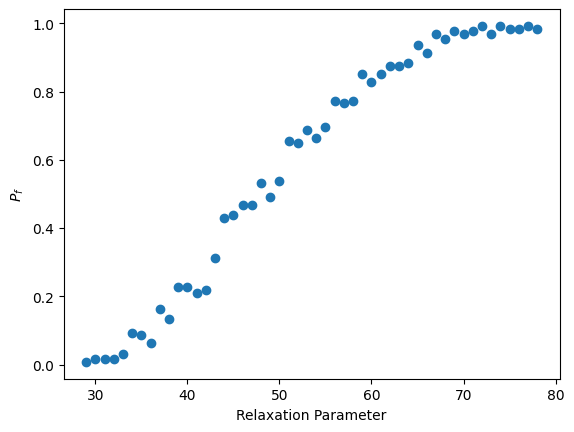

In [42]:
file_path = process_tsp_files_in_folder('TestTSPFolder')
nodes_matrix, distance_matrix = parse_tsp_file(file_path)
pf_arr = [0 for i in range(50)]
nrg_arr=[0 for i in range(50)]
r = [i for i in range(29,79)]
for i in r:
    p_f, energy = solve_for_instances(file_path, nodes_matrix, i)
    pf_arr[i-29] = p_f
    nrg_arr[i-29] = energy
plt.scatter(r,pf_arr)
plt.xlabel("Relaxation Parameter")
plt.ylabel("$P_f$")
plt.show()

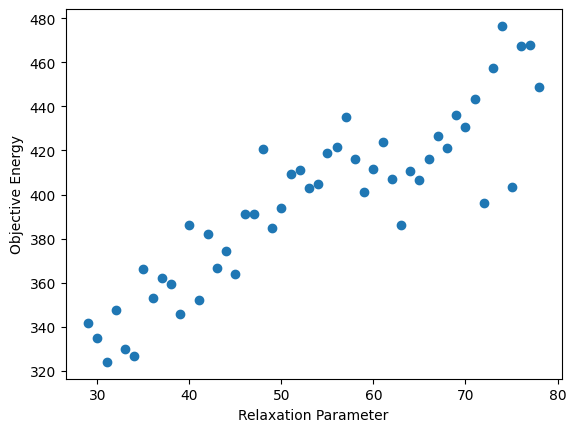

In [45]:
plt.scatter(r, nrg_arr)
plt.ylabel("Objective Energy")
plt.xlabel("Relaxation Parameter")
plt.show()